references used to elaborate this code are : 
https://keras.io/getting-started/sequential-model-guide/
https://keras.io/layers/wrappers/#bidirectional
https://github.com/keras-team/keras
https://machinelearningmastery.com/

In [6]:
# univariate data preparation
from numpy import array
import numpy
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
        
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value. here the scaler.inverse_transform is used directly
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [7]:
import pandas as pd
import numpy 
from matplotlib import pyplot

series = pd.read_csv('Daily_TSNew_i-001683a6-rp-static-server-15197471722.csv', index_col=[0])

series.shape
series = series.values
series.shape


(25911, 1)

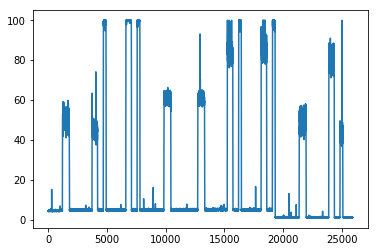

In [8]:
pyplot.plot(series)

In [29]:
# split into train and test sets
train_size = int(len(series) * 0.67)
train_size, 
train, test = series[0:train_size,:], series[train_size:len(series),:]
train.shape, test.shape


 
#scaler, train_scaled, test_scaled = scale(train, test)
#train_scaled, test_scaled
#train = train_scaled
#test = test_scaled
#train, test

((17360, 1), (8551, 1))

In [16]:
# here we construct the supervised problem table
 
n_steps=1

#seriesX, seriesy = split_sequence(series, n_steps)
#seriesX.shape, seriesy.shape
#create trainseriesX and trainseriesy 
trainseriesX, trainseriesy = split_sequence(train, n_steps)


#create testseriesX and testseriesy
testseriesX, testseriesy = split_sequence(test, n_steps)
trainseriesX.shape, testseriesX.shape

((17359, 1, 1), (8550, 1, 1))

In [17]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import numpy as np

In [18]:

#Usecase2 config
# to always shape the data as [samples, timesteps, features]
# reshape from [samples, timesteps] into [samples, timesteps, features]

n_features = 1

#seriesX = seriesX.reshape((seriesX.shape[0], seriesX.shape[1], n_features))
trainseriesX = trainseriesX.reshape((trainseriesX.shape[0], trainseriesX.shape[1], n_features))
# #scenario1 config

model = Sequential()
model.add(LSTM(4, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model, to_file='usecase2.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Usecase3 config
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
plot_model(model, to_file='usecase3.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Usecase4 config
from keras.layers import Bidirectional
# define model
model = Sequential()
model.add(Bidirectional(LSTM(4, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
plot_model(model, to_file='usecase4', show_shapes=True, show_layer_names=True)

In [19]:
from math import sqrt
import math
from sklearn.metrics import mean_squared_error

# demonstrate prediction, the rule is to have the test as testseriesX = testseriesX.reshape(1, n_steps, n_features)

testseriesX = testseriesX.reshape((testseriesX.shape[0], testseriesX.shape[1], n_features))

# in general the input should be as x_input = x_input.reshape((1, n_steps, n_features))

repeats = 30
error_trainscores = list()
#error_testscores = list()

for r in range(repeats):
    # fit model
    #from keras.callbacks import EarlyStopping
    #early_stopping = EarlyStopping(monitor='loss', patience=2)
    
    #starting the training on trainseriesX with known trainseriesy
    #model.fit(trainseriesX, trainseriesy, epochs=100, callbacks=[early_stopping], verbose=0)
    model.fit(trainseriesX, trainseriesy, epochs=100, verbose=0)
    
    #perform the prediction on the train and test
    trainPredict = model.predict(trainseriesX, batch_size=32, verbose =0)
 
    # calculate root mean squared error for train and test 
    trainScore = math.sqrt(mean_squared_error(trainseriesy, trainPredict))
    
    #report performance for train
    print('%d) Train RMSE: %.3f' % (r+1, trainScore))
    error_trainscores.append(trainScore)
  

1) Train RMSE: 1.703
2) Train RMSE: 1.698
3) Train RMSE: 1.695
4) Train RMSE: 1.696
5) Train RMSE: 1.697
6) Train RMSE: 1.704
7) Train RMSE: 1.694
8) Train RMSE: 1.702
9) Train RMSE: 1.691
10) Train RMSE: 1.699
11) Train RMSE: 1.691
12) Train RMSE: 1.741
13) Train RMSE: 1.688
14) Train RMSE: 1.694
15) Train RMSE: 1.687
16) Train RMSE: 1.688
17) Train RMSE: 1.687
18) Train RMSE: 1.695
19) Train RMSE: 1.698
20) Train RMSE: 1.700
21) Train RMSE: 1.688
22) Train RMSE: 1.689
23) Train RMSE: 1.715
24) Train RMSE: 1.690
25) Train RMSE: 1.686
26) Train RMSE: 1.688
27) Train RMSE: 1.686
28) Train RMSE: 1.686
29) Train RMSE: 1.688
30) Train RMSE: 1.686


       trainScore
count   30.000000
mean     1.694952
std      0.010971
min      1.686175
25%      1.687810
50%      1.692625
75%      1.698238
max      1.740665


<Figure size 1440x360 with 0 Axes>

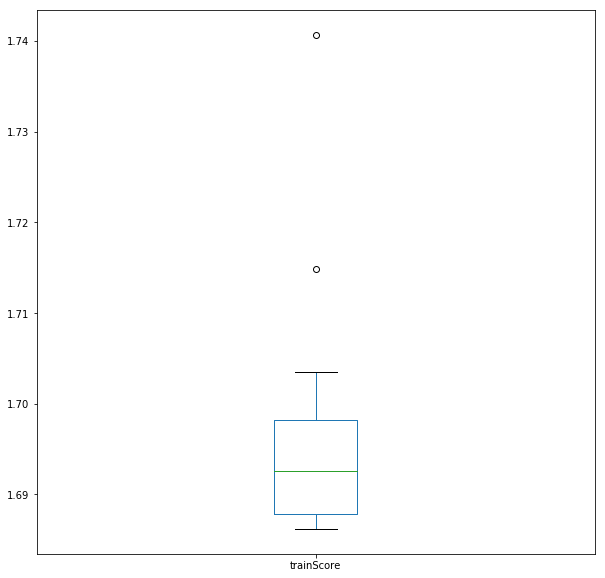

In [20]:
pyplot.figure(figsize=(20,5))

from pandas import DataFrame
# summarize Train results and check the minimum RMSE on training data
resultsTrain = DataFrame()
resultsTrain['trainScore'] = error_trainscores
print (resultsTrain.describe())
resultsTrain.plot(kind='box', subplots=None, layout=(2,2), sharex=False, sharey=False, figsize=(10,10))

In [21]:
testPredict = model.predict(testseriesX, batch_size = 32, verbose=0)
testScore = math.sqrt(mean_squared_error(testseriesy, testPredict))
#report performance for test
print('Test RMSE: %.3f' % (testScore))

Test RMSE: 2.875


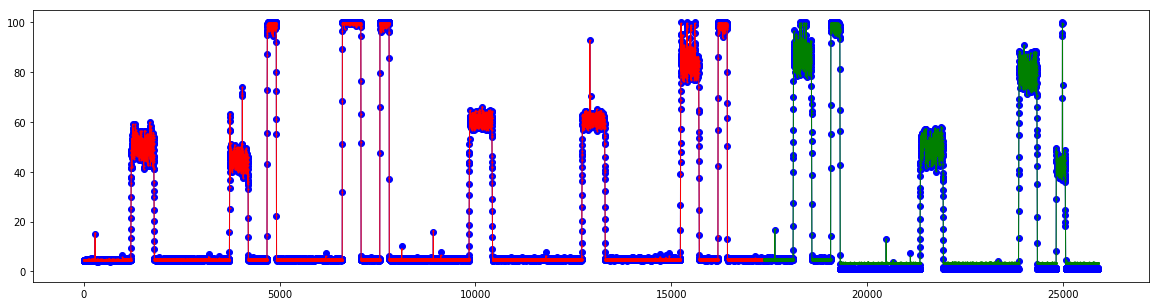

In [22]:
import matplotlib.pyplot as plt
pyplot.figure(figsize=(20,5))
look_back=n_steps
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(series)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(series)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back):len(series)-1, :] = testPredict
# plot baseline and predictions
plt.plot(series,color='blue',label="True",marker = 'o', linewidth=1, markersize=6)
plt.plot(trainPredictPlot,color='red',label="True",marker = 'o', linewidth=1, markersize=1)
plt.plot(testPredictPlot,color='green',label="Forecasting", marker = 'o', linewidth=1, markersize=1)
#plt.plot(scaler.inverse_transform(series))
#pyplot.plot(series)
#pyplot.plot(trainPredictPlot)
#pyplot.plot(testPredictPlot)
#pyplot.show()

summary of results are below. 

## Usecase2: 
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()


lag = 5
Train Score: 1.46 RMSE
Test Score: 2.18 RMSE

lag = 1
Train Score: 1.69 RMSE
Test Score: 2.25 RMSE

## Usecase3
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

lag=1
Train Score: 1.83 RMSE
Test Score: 2.53 RMSE

lag=5
Train Score: 1.49 RMSE
Test Score: 2.07 RMSE


## Usecase4
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

lag=1
Train Score: 1.74 RMSE
Test Score: 2.25 RMSE

lag=5
Train Score: 1.46 RMSE
Test Score: 2.34 RMSE

lag=1 
nbr de neuronnes = 4
Train Score: 1.69 RMSE
Test Score: 2.13 RMSE

Train Score: 1.71 RMSE
Test Score: 2.14 RMSE
